# Explainer Notebook
This notebook was written by:
* Martin Petersson, s103619
* Christoffer Jensen, s103148

## Motivation
We have chosen to collect data from the Game of Thrones universe. The data was collected from various sites and API's, such as:
* *API's*:
    * https://api.got.show/api/
* *Sites*:
    * http://gameofthrones.wikia.com/wiki/

*Description of dataset: * 

> We have collected all the characters from Game of Thrones. For each character we have also collected their wikia page and which house they belong to (for community detection)
Some of this data was accesible through the API at https://api.got.show/api/, but most wasn't why we had to parse the web pages of the pages found at http://gameofthrones.wikia.com/wiki/.

> This resulted in a Python dictionary containing 1062 characters from the Game of Thrones universe. Each entry in the dictionary contains two elements.
>
    1) The name of the house that the character is affiliated with. 
    2) A set of links from the character's wikia page.
> Furthermore, we have retrieved and created another dictionary containing information on the different houses in GoT.
An entry simply has the name of the house as key and a list of the members of the house as value.

## Basic stats
* Write about your choices in data cleaning and preprocessing

When we retrieve the wikia page of each character, we use the BeautifulSoup library to get the HTML page. Since we only need a fraction of the page, everything else is filtered out. The remaining part of the page is also cleaned, as we are only interested in the internal links on the page, and the house information (*if it's present for the given character*).

* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

## Tools, theory and analysis
* Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

We have used a number of tools to analyse the data we have retrieved, such as:
> * *Centrality measures (Degree, betweenness and eigenvector)*

Centrality is used to discover the most important nodes in a network based on different properties of the graph. We have used these measures to discover which of the characters have highest importance in the GoT univserse, and whether there is a difference depending on the used measure. 
* *Degree centrality* ranks a node high if it has high degree, which indicates that there are many paths in the network through this particular node. It will be a different measure depending on whether you look at in-degree or out-degree or total degree. We have used total degree in this case, since we are interested in characters that are both highly referenced but only have reference to many others.
* *Betweenness centrality* ranks a node based on the number of shortest paths that includes the particular node. This tells something about how the node ties the network together, since it might be more sparse if it wasn't for this node (or more dense if you are looking at a node with low betweenness centrality). 
* *Eigenvector centrality* is a measure that ranks a node higher if it is connected to a node with high eigenvector centrality. This means that nodes are "rewarded" for linking to significant nodes in the network.

> Degree distribution

This is a tool that can be used to discover whether the distribution of degrees in the network follows a certain type of distribution (Poissonian, Power-law, etc). As there are different properties defined for each type of distribution, it would be nice to see if our data fit any of the types or not.

> Communitiy detection and modularity

The Game of Thrones universe contains some predefined communities, as characters are grouped into houses depending on their familiy or inheritance. Using the network we have built, we will examine whether these predefined houses are good communities or not. Maybe there exist some other communities as well that we will discover. We will look into the modularity of the communities, to see whether they are actually good communities. Modularity describes whether a set of nodes form a "good" community. A good community is one where there are more links in the community than expected (by probability). On the other hand, a bad community is one where the conncetions between nodes is random. Modularity can also discover whether a given set of nodes form a community at all. 


To get started analysing the GoT universe, we built a network (directed graph) with a node for each character and a link from character1 to character2 if there is a link to character2 from character1's wikia page.


### Methods explained:
>  ==================================================================================================================

> $\texttt{getCharacters()}$  
Retrives a dictionary over the characters of GoT. The value of each character is a dictionary containing *id*, *page*, and *house* information. These values will be filled in later.

> $\texttt{getHouseForCharacters(characters)}$  
Retrieves the house information for each character, if this information can be extracted from the site. The *characters[character]['house']* value is then updated, if house information is found. 

> $\texttt{getHouses(minCount)}$  
Returns a dictionary, with house as key, and a dictionary containing a list of members in the house and the number of members, as value. For the houses in GoT with more than *minCount* members.

> $\texttt{getLinks(characters)}$  
Returns an updated version of the *characters* dictionary, where the page element of each character has been set. Here, the BeautifulSoup library is used to retrieve the relevant parts of the characters' web page. Furthermore, we do not save the entire web page, but only the internal links it contains.

> $\texttt{createGoTNetwork(characters)}$  
Returns a DiGraph with characters as nodes and an edge between two characters if there is a link from the page of the first character to the other. The method also returns another DiGraph, which is the largest weakly connected component (G_wcc).

>  ==================================================================================================================

In [1]:
import json, operator, community
from urllib2 import urlopen
from bs4 import BeautifulSoup
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import cPickle as pickle
%matplotlib inline

def loadFile(filename):
    characters = pickle.load(open(filename, "rb" ))
    return characters

def saveFile(filename, content):
    pickle.dump(content, open(filename, "wb" ))
    
def prettifyName(name):
    name = name.replace('_',' ') if '_' in name else name
    return name

# retrieve the characters from the GoT wikia page. Save them in a dictionary.
def getCharacters():
    response = urlopen('http://gameofthrones.wikia.com/api/v1/Articles/List?expand=1&category=Characters&limit=10000')
    html = response.read()
    j = json.loads(html)

    characters = dict()
    for i in j['items']:
        if i['type'] == 'article':
            if not i['title'].startswith("Sandbox/"):
                title = i['title'].replace(' ', '_')
                characters[title] = {'id': i['id'], 'page' : set(), 'house' : None}
    return characters

# retrieve the house information for the characters and update the dictionary with the new information.
def getHouseForCharacters(characters):
    base = 'https://api.got.show/api/characters/'
    response = urlopen(base)
    html = response.read()
    chars = json.loads(html)
    for c in chars:
        name = c['name'].replace(' ', '_')
        if name in characters:
            if 'house' in c:
                characters[name]['house'] = c['house']    
    return characters

# retrieve all houses in the GoT universe, with *minCount* members.
def getHouses(minCount=5):
    houses = dict()
    for k,v in characters.iteritems():
        h = v['house']
        if h != None:
            if h in houses:
                houses[h]['count'] += 1
                houses[h]['members'].append(k)
            else:
                houses[h] = dict()
                houses[h]['count'] = 1
                houses[h]['members'] = list()
                houses[h]['members'].append(k)
            
    houses = {k: v for k,v in houses.iteritems() if v['count'] > minCount}
    return houses

# retrieve all links from the web page of a character, and update the characters dictionary with the new information.
def getLinks(characters):
    baseUrl = 'http://gameofthrones.wikia.com/wiki/'
    for char,v in characters.iteritems():
        url = baseUrl + char
        response = urlopen(url)
        source = response.read()
        soup = BeautifulSoup(source)
        div = soup.find(id="mw-content-text")
        ps = div.findChildren('p')
        for p in ps:
            hr = p.findChildren('a')
            if p.parent.name != 'td':
                for h in hr:
                    if h.has_attr('href'):
                        if h['href'].startswith('/wiki'):
                            ele = h['href'].split('/')[-1:][0]
                            if '?' not in ele and 'Category' not in ele and 'Season' not in ele and not ele.startswith('File'):
                                v['page'].add(ele) 
    return characters

# Print information about the houses, in a table.
def printHousesInfo(houses):
    sorted_houses = sorted(houses.items(), key=operator.itemgetter(1), reverse=True)
    house_table = PrettyTable(['House', 'Number of characters'])
    for h in sorted_houses:
        house_table.add_row([h[0], h[1]['count']])
    return house_table

# create a directed graph over the characters and their links.
def createGoTNetwork(characters):
    G = nx.DiGraph()
    G.add_nodes_from(characters.keys())
    for k,v in characters.iteritems():
        for name in characters.keys():
            if name != k:
                if name in v['page']:
                    G.add_edge(k, name)
    G_wcc = max(nx.weakly_connected_component_subgraphs(G),key=len)
    return G, G_wcc

# Print the networks.
def printNetworks(G, G_wcc):
    plt.figure(1,figsize=(12,12))
    pos = nx.layout.fruchterman_reingold_layout(G)
    nx.draw(G, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.25', with_labels=False, width=.5, pos=pos)
    plt.title('Full GoT network')
    plt.show()
    print "Network size : #nodes: {0}, #edges {1}".format(len(G.nodes()), len(G.edges()))

    plt.figure(2,figsize=(12,12))
    pos = nx.layout.fruchterman_reingold_layout(G_wcc)
    nx.draw(G_wcc, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.25', with_labels=False, width=.5, pos=pos)
    plt.title('The largest component in the GoT network')
    plt.show()
    print "Network size : #nodes: {0}, #edges {1}".format(len(G_wcc.nodes()), len(G_wcc.edges()))

# Print statistics of the graph, (i.e. degree, betweenness centrality, eigenvector centrality)
def printGraphStats(G_wcc, top=10):
    sorted_G_out_deg = sorted(G_wcc.out_degree().items(), key=operator.itemgetter(1), reverse=True)
    sorted_G_in_deg = sorted(G_wcc.in_degree().items(), key=operator.itemgetter(1), reverse=True)
    sorted_G_degree = sorted(G_wcc.degree().items(), key=operator.itemgetter(1), reverse=True)
    deg_table = PrettyTable(['Character - In degree',' Character - Out degree', 'Character - Total degree'])
    
    for i in range(top):
        a = ["%s, %d" % (prettifyName(sorted_G_in_deg[i][0]), sorted_G_in_deg[i][1]),
            "%s, %d" % (prettifyName(sorted_G_out_deg[i][0]), sorted_G_out_deg[i][1]),
            "%s, %d" % (prettifyName(sorted_G_degree[i][0]), sorted_G_degree[i][1])]
        deg_table.add_row(a)
    
    G_bc = nx.betweenness_centrality(G_wcc)
    G_bc_sorted = [(k, G_bc[k]) for k in sorted(G_bc, key=G_bc.get, reverse=True)]

    bc_table = PrettyTable(['Character', 'Betweenness centrality'])
   
    for i in range(top):
        a = [prettifyName(G_bc_sorted[i][0]),
            "%.3f" % G_bc_sorted[i][1]]
        bc_table.add_row(a)

    ec_table = PrettyTable(['Character', 'Eigenvector centrality (In-degree)',' Character', 'Eigenvector centrality (Out-degree)'])
    G_ec_in = nx.eigenvector_centrality(G_wcc)
    G_ec_out = nx.eigenvector_centrality(G_wcc.reverse())
    G_ec_in_sorted = [(k, G_ec_in[k]) for k in sorted(G_ec_in, key=G_ec_in.get, reverse=True)]
    G_ec_out_sorted = [(k, G_ec_out[k]) for k in sorted(G_ec_out, key=G_ec_out.get, reverse=True)]    
    
    
    for i in range(top):
        a = [prettifyName(G_ec_in_sorted[i][0]), 
             "%.4f" % G_ec_in_sorted[i][1],
            prettifyName(G_ec_out_sorted[i][0]),
            "%.4f" % G_ec_out_sorted[i][1]
            ]
        ec_table.add_row(a)
    return deg_table, bc_table, ec_table

# Plot the degree distribution of the graph. Set loglog=True for the plot with logarithmic axes.
def degreeDistPlots(G, loglog=False):
    # Plot the distribution of in-degrees
    plt.figure(1, figsize=(12,6))
    h1, be1 = np.histogram(G.in_degree().values(), bins='sqrt')
    h2, be2 = np.histogram(G.out_degree().values(), bins='sqrt')
    if loglog:
        plt.loglog(be1[:-1],h1,'-o')
        plt.xlim([0, pow(10, 2.13)])
        plt.ylim([0, pow(10, 2)])
        plt.title("Distribution of in-degrees loglog scale")
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.loglog(be2[:-1],h2,'-o')        
        plt.xlim([0, pow(10, 1.76)])
        plt.ylim([0, pow(10, 2.4)])
        plt.title("Distribution of out-degrees loglog scale")
        plt.show()
    else:
        plt.plot(be1[:-1], h1, '-r', label='In-degree')
        plt.plot(be2[:-1], h2, '-b', label='Out-degree')
        plt.title("Distribution of in- and out-degrees")
        plt.xlabel("Degree (k)")
        plt.ylabel("Number of nodes with degree k")
        plt.legend()
        plt.show()
        
# Plot a scatter plot over the degrees.
def degreeScatterPlot(G):
    x = range(len(G.nodes()))
    plt.figure(figsize=(10, 5))
    plt.scatter(x, G.in_degree().values(), c='r')
    plt.scatter(x, G.out_degree().values(), c='w')
    plt.legend(["in degree", "out degree"], loc=2)
    plt.ylim([pow(10,-0.1), pow(10, 2.1)])
    plt.xlim([pow(10,-0.1), pow(10,3.1)])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Node")
    plt.ylabel("Degree")
    plt.show()
    
# Calculate the modularity of the predefined houses (using equation 9.12)
def calculateHouseModularity(houses):
    n_c = len(houses)
    m1 = 0; L1 = 0; k1 = 0
    for house, v in houses.iteritems():
        v['L'] = int(); v['k'] = int(); v['M'] = float(0);
        for member in v['members']:
            v['k'] += G.degree(member)
            for m in G.edges(member):
                if (m[0] != member and m[0] in v['members']) or (m[1] != member and m[1] in v['members']):
                    v['L'] += 1
    L = sum([v['k'] for v in houses.values()])

    for k,v in houses.iteritems():
        l_c = float(v['L']); k_c = float(v['k'])
        v['M'] = (l_c / L) - (pow((k_c / (2 * L)), 2.0))
    return houses

# Print the modularity for each house, in a table.
def houseModularityTable(houses):
    mt = PrettyTable(['House', 'L_c', 'k_c', 'M_c'])
    for k, v in houses.iteritems():
        mt.add_row([k, v['L'], v['k'], "%.5f" % v['M']])
    return mt

# Retrieve the communities using the Louvain algorithm, and print the corresponding network.
def showCommunityGraph(H):
    plt.figure(figsize=(10,10))
    partition = community.best_partition(H)
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(H)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(H, pos, list_nodes, node_size = 20, node_color = str(count / size))
    nx.draw_networkx_edges(H, pos, alpha=0.5)
    plt.axis('off')
    plt.show()
    
# Calculate the confusion matrix, given a undirected version of the network. 
def calculateConfusionMatrix(H):
    partition = community.best_partition(H)
    houses = getHouses()
    modularity = community.modularity(partition, H)
    noCommunities = max(partition.values())
    D = np.zeros((len(houses), noCommunities))
    for i in range(len(houses)):
        for j in range(noCommunities):
            for v in partition:
                if partition[v] == j:
                    if v in houses.values()[i]['members']:
                        D[i,j] += 1
    return D, modularity, noCommunities

# Plot the distribution of the elements in the confusion matrix (diagonal and non-diagonal elements.)
def confusionMatrixDist(D):
    diag = [D[i,j] for i in range(D.shape[0]) for j in range(D.shape[1]) if i == j]
    nondiag = [D[i,j] for i in range(D.shape[0]) for j in range(D.shape[1])if i != j]
    a, b = np.histogram(diag)
    a1, b1 = np.histogram(nondiag)

    plt.figure(1)
    plt.plot(b[:-1], a)
    plt.yticks(range(int(max(a))+1))
    plt.title("Distribution of diagonal elements")
    plt.show()

    plt.figure(2)
    plt.plot(b1[:-1], a1)
    plt.title("Distribution of non-diagonal elements")
    plt.show()

In [4]:
# characters = getCharacters()
# characters = getHouseForCharacters(characters)
houses = getHouses()
# characters = getLinks(characters)
print len([c['house'] for c in characters.values() if c['house'] != None]), '/', len(characters), 'characters belong to a house.'
# print "Saving", len(characters), "characters, their pages and house info."
# saveFile('got/characters.p', characters)

377 / 1062 characters belong to a house.


In [5]:
characters = loadFile("got/characters.p")

### Basic stats about the dataset.

In [6]:
print "The dataset contains {0} characters and {1} houses, where {2} characters has connection to a house.".format(len(characters), len(houses), sum([v['count'] for v in houses.values()]))
print "There are {0} internal links in total. The character with most links has {1} links.".format(sum([len(v['page']) for v in characters.values()]), max([len(v['page']) for v in characters.values()]))

The dataset contains 1062 characters and 11 houses, where 190 characters has connection to a house.
There are 20697 internal links in total. The character with most links has 139 links.


*Communities defined in GoT.*

In [7]:
print "The following communities are defined in GoT.\n"
print printHousesInfo(houses)

The following communities are defined in GoT.

+--------------------+----------------------+
|       House        | Number of characters |
+--------------------+----------------------+
|  House Targaryen   |          46          |
|   Night's Watch    |          30          |
|    House Stark     |          30          |
|   House Martell    |          18          |
|  House Lannister   |          16          |
|   House Greyjoy    |          14          |
|     House Frey     |          10          |
| Faith of the Seven |          7           |
|    House Arryn     |          7           |
|    House Tyrell    |          6           |
|    House Tully     |          6           |
+--------------------+----------------------+


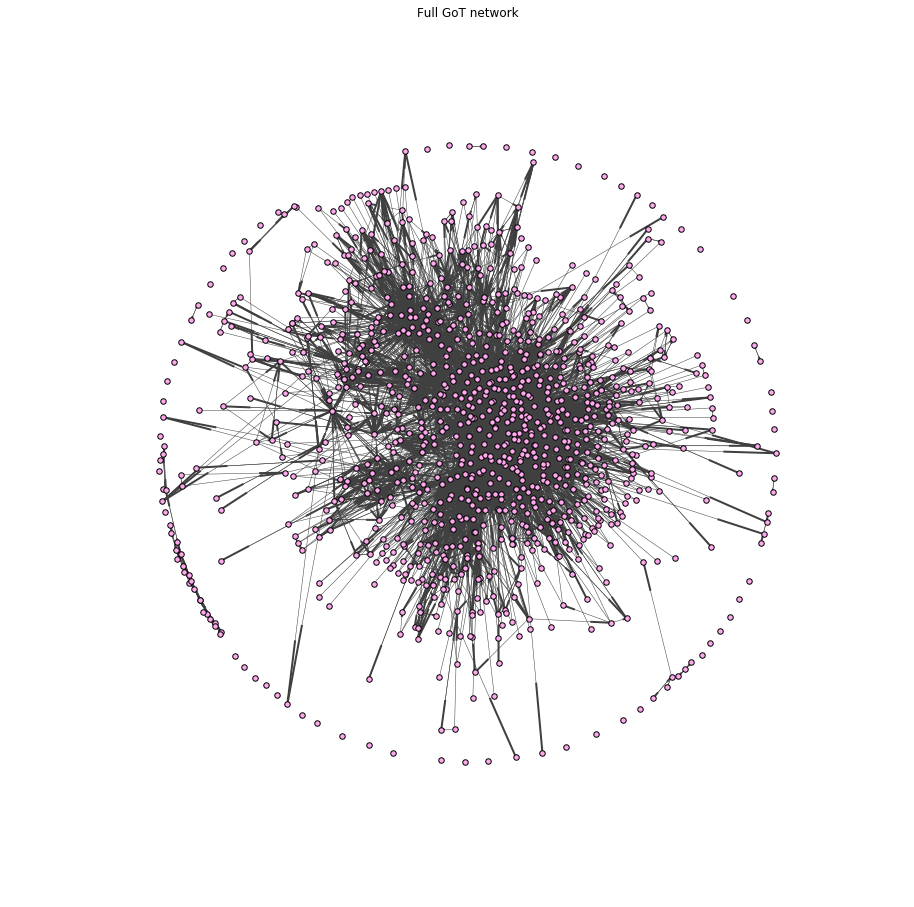

Network size : #nodes: 1062, #edges 7985


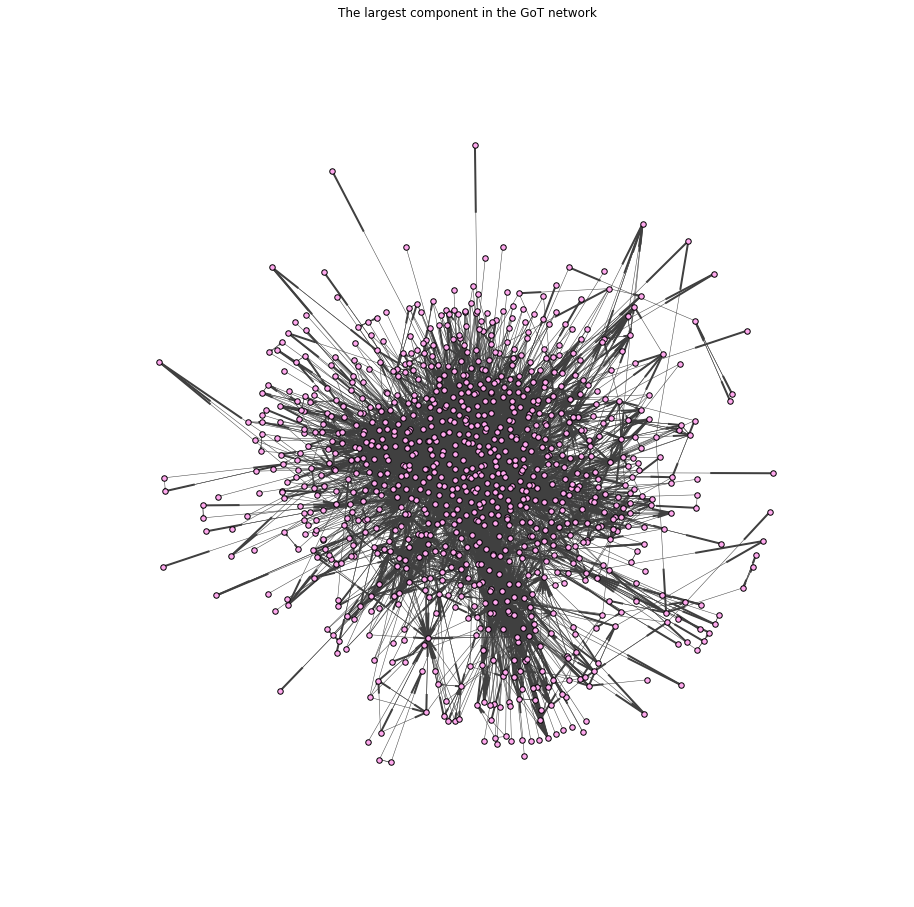

Network size : #nodes: 972, #edges 7907


In [8]:
G, G_wcc = createGoTNetwork(characters)
printNetworks(G, G_wcc)

## Network statistics
The tables below show the top 10 ranked characters in terms of the three different centrality measures (degree, betweenness, and eigenvector).

In [25]:
top = 10
deg_table, bc_table, ec_table = printGraphStats(G_wcc, top=top)
print "The top %d GoT characters in terms of in-degree, out-degree and total degree (in + out degree):" %top
print deg_table
print "\nThe top %d Game of Thrones characters in terms of betweenness centrality:" % top   
print bc_table
print "\nThe top %d Game of Thrones characters in terms of eigenvector centrality (In degree and out degree)" % top
print ec_table

The top 10 GoT characters in terms of in-degree, out-degree and total degree (in + out degree):
+-------------------------+-------------------------+--------------------------+
|  Character - In degree  |  Character - Out degree | Character - Total degree |
+-------------------------+-------------------------+--------------------------+
|  Tyrion Lannister, 187  |   Tyrion Lannister, 63  |  Tyrion Lannister, 250   |
|      Jon Snow, 170      |       Jon Snow, 57      |      Jon Snow, 227       |
| Daenerys Targaryen, 146 |     Eddard Stark, 56    |    Eddard Stark, 195     |
|     Robb Stark, 146     |        Varys, 54        | Daenerys Targaryen, 192  |
|    Eddard Stark, 139    |    Catelyn Stark, 53    |   Jaime Lannister, 183   |
|   Jaime Lannister, 138  |    Petyr Baelish, 50    |     Robb Stark, 180      |
|     Sansa Stark, 128    |    Theon Greyjoy, 50    |     Sansa Stark, 174     |
|  Stannis Baratheon, 125 |   Cersei Lannister, 48  |  Cersei Lannister, 166   |
|  Joffrey Ba

> The characters with the highest *betweenness centrality* are most likely the most famous. These have high betweenness centrality as they are referenced most times and thus they might act as a link between different parts of the GoT universe.


> *Eigenvector centrality* ranks a node higher if it is connected to a high-degree node than to a low-degree node.
This means that nodes with high-degree eighbors will get a higher eigenvector centrality than degree centrality, as degree centrality only takes that number of direct neighbors into account.

> There is a correlation between the pages with high *betweenness centrality* and high *eigenvector centrality* (for in degree) as these seem to be quite similar. It makes sense that the correlation is towards in degree and not out degree, since it is more likely that a bunch of characters refer to the same character and not the other way around.

Since the centrality measures did not reveal anything surprising, what about the assortativity then?

In [14]:
H = G_wcc.to_undirected()
print "The degree assortativity coefficient of the undirected GoT network is %.2f" % nx.degree_assortativity_coefficient(H)

The degree assortativity coefficient of the undirected GoT network is -0.14


Since the assortativity value of the undirected version of the GoT network is negative, it means that high-degree characters do not tend to link to other high-degree characters. The same is true for low-degree characters. Instead there might be a bunch of low-degree characters that links to all the high-degree characters, i.e. the tendency is that a low-degree characters is more likely to link to a high-degree character.

Let us take a look at the degree distribution below.

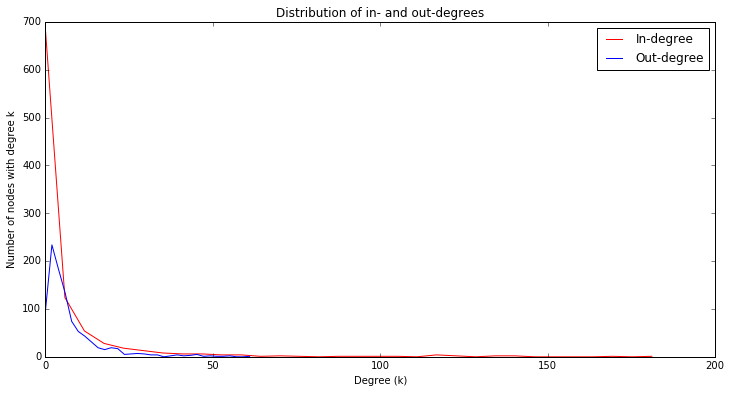

In [29]:
degreeDistPlots(G_wcc)

The most common degree seems to be in the range from 0-5, for both in- and out-degree.

To discover whether the distribution can be described as a well-known type (i.e. Poissonian), we'll consider the distribution in a loglog plot:

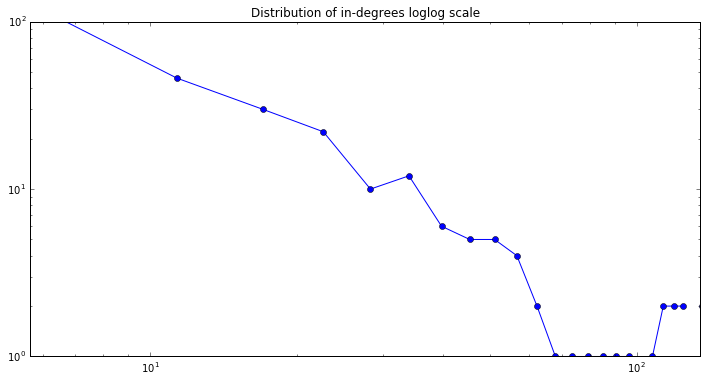

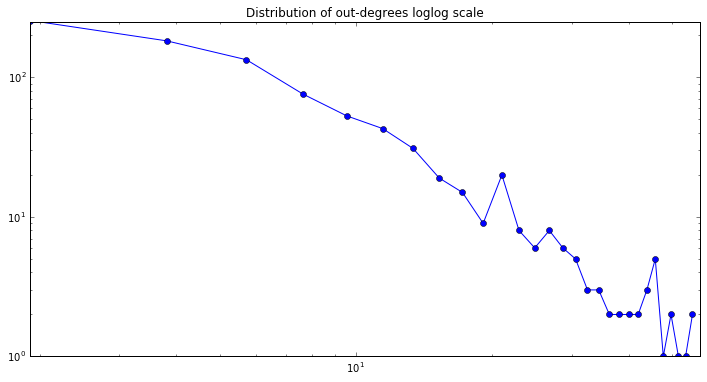

In [32]:
degreeDistPlots(G, loglog=True)

* Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?
> The distributions shown above looks like they do not follow a power-law as they look more Poissonian. The graphs are not linear enough to be following a power-law.

## The houses of GoT. Are they communities?
* First, we will calculate the modularity, using equation 9.12 (Barabasi, Network Science)

**Equation 9.12:**
$$M=\sum\limits_{c=1}^{n_c}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^2 \right]$$

$n_c$: Number of communities  
$L_c$: The total number of links within the community $C_c$  
$k_c$: The total degree of the nodes in the community $C_c$  
A node's *total degree*, $k_i$ is given by: $k_i=k_i^{in}+k_i^{out}$

In [33]:
houses = calculateHouseModularity(getHouses(4))
print houseModularityTable(houses),'\n'

+--------------------+-----+------+---------+
|       House        | L_c | k_c  |   M_c   |
+--------------------+-----+------+---------+
|  House Hightower   |  1  |  73  | 0.00013 |
|  House Lannister   |  67 | 1055 | 0.00358 |
|   Night's Watch    |  48 | 478  | 0.00624 |
|   House Martell    |  48 | 307  | 0.00710 |
|   House Greyjoy    |  38 | 295  | 0.00554 |
|     House Frey     |  19 | 166  | 0.00287 |
| Faith of the Seven |  10 |  87  | 0.00156 |
|    House Stark     | 124 | 1529 | 0.00484 |
|  House Baratheon   |  4  | 164  | 0.00047 |
|    House Tully     |  18 | 365  | 0.00203 |
|    House Tyrell    |  14 | 235  | 0.00189 |
|  House Targaryen   | 256 | 1364 | 0.02912 |
|    House Arryn     |  5  | 107  | 0.00073 |
+--------------------+-----+------+---------+ 



### Modularity
The modularity value for each of the communities are positive, which means that they all are potential communities. This is great results, since they indeed should be communities. Later, we will explore whether the Louvain algorithm agrees with the fact that the communities are well-defined.

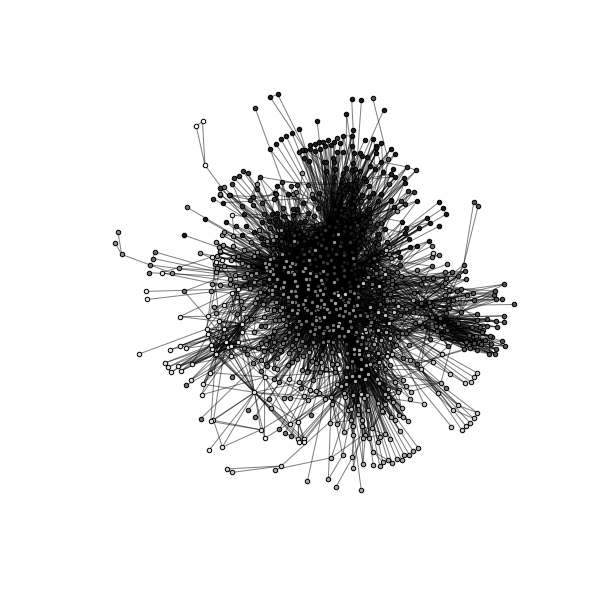

In [21]:
H = G_wcc.to_undirected()
showCommunityGraph(H)

In [50]:
D, modularity, noCom = calculateConfusionMatrix(H)
print "Modularity M calculated using Eq. 9.12 = %.3f" % sum([v['M'] for v in houses.values()])
print "Modularity M calculated using the Louvain algorithm = %.3f\n" % modularity

Modularity M calculated using Eq. 9.12 = 0.066
Modularity M calculated using the Louvain algorithm = 0.492



The *Louvain* algorithm found a higher modularity value then we computed using Equation 9.12. This suggests that the defined communities in the GoT universe, seems to be communities indeed. There is no indication yet that the communities could be ill-defined. To investigate this, we will look at the confusion matrix.

In [51]:
print "The Louvain algorithm found {0} communities in the graph.".format(noCom)
print D

The Louvain algorithm found 8 communities in the graph.
[[  0.   0.   2.   8.   4.   1.   1.   0.]
 [ 24.   3.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   3.  15.   0.   0.   0.   0.]
 [ 13.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.  10.   0.   0.   0.]
 [  0.   0.   1.   5.   0.   0.   1.   0.]
 [ 12.   6.   1.   3.   5.   0.   0.   0.]
 [  0.   0.   0.   0.   5.   0.   1.   0.]
 [  0.   0.   0.   6.   0.   0.   0.   0.]
 [  0.   0.  34.   0.   0.  10.   2.   0.]
 [  0.   0.   1.   0.   5.   1.   0.   0.]]


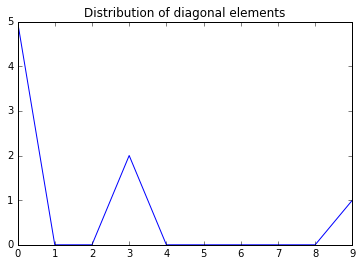

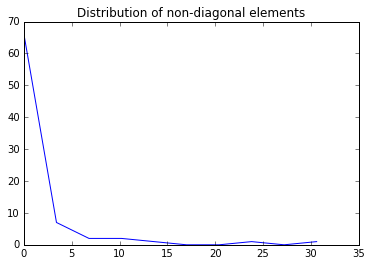

In [52]:
confusionMatrixDist(D)

The two graphs shows the distribution between the diagional and non-diagonal elements of the confusion matrix. If the distribution of the diagonal elements is skewed to the right and the distribution of the non-diagonal elements are skewed to the left, this indicates that the communities are well-defined since they do not have many links between them. 

In this case, the non-diagonal distribution is skewed to the left, but there are also some high values of non-diagonal elements that indicates that there exists some communities with a high number of links between them. the distribution of diagonal elements are not skewed to the right completely. This means that we cannot conclude that the predefined communities are well-defined, as this suggests that other communities exists in the GoT universe. This is not completely surprising since some characters change house during the series, and this is not something that we have accounted for in our data extraction.